In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_excel('data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df_copy = df.copy()

In [4]:
df = df_copy.copy()

In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<div class="alert alert-danger"> Quantity and unit price are negative which they shouldn't be </div>

In [8]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [9]:
df['CustomerID'].value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [10]:
df['InvoiceNo'].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
556310        1
556311        1
556312        1
556313        1
C543775       1
Name: InvoiceNo, Length: 25900, dtype: int64

In [11]:
df['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

## Data Cleaning

In [12]:
# Drop CustomerID NaN
df.dropna(subset=['CustomerID', 'Quantity', 'UnitPrice'], inplace=True)
df['Description'] = df['Description'].str.strip()
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

### Remove rows where Qty or Unit Price < 0

In [13]:
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [14]:
df[df['UnitPrice'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [15]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [16]:
df.sort_values(by=['Quantity'], ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom


### Remove the time from InvoiceDate

In [17]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'].dt.date)

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


### Check stock codes

In [19]:
df[df['StockCode'].str.isalpha()==True].drop_duplicates(subset=['StockCode'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01,18.000,12583.0,France
2239,536569,M,Manual,1,2010-12-01,1.250,16274.0,United Kingdom
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15,0.001,13952.0,United Kingdom
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30,11.170,14096.0,United Kingdom


In [20]:
#I do not want POSTAGE or Manual or DOTCOM POSTAGE
df = df[~df['StockCode'].isin(['POST', 'M', 'DOT'])]

In [21]:
df.shape

(396485, 8)

## EDA

### Plot  Number of items over time by Quantity

In [22]:
df.sort_values(by=['Quantity'], ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27,0.72,13135.0,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22,0.82,18087.0,United Kingdom


<div class="alert alert-danger"> Since there are 2 transactions which are outliers in terms of quantity -- we will be ignoring them for our chart </div>

In [23]:
qty_date = df[df['Quantity']<70000]

In [24]:
qty_date['InvoiceDay'] = qty_date['InvoiceDate'].apply(lambda x: x.strftime('%m-%d'))
qty_date['InvoiceDay'] = pd.to_datetime(qty_date['InvoiceDay'], format='%m-%d')

<ipython-input-24-989ce1caa3cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qty_date['InvoiceDay'] = qty_date['InvoiceDate'].apply(lambda x: x.strftime('%m-%d'))
<ipython-input-24-989ce1caa3cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qty_date['InvoiceDay'] = pd.to_datetime(qty_date['InvoiceDay'], format='%m-%d')


In [25]:
qty_date = qty_date.groupby(['InvoiceDay'])['Quantity'].sum().reset_index()

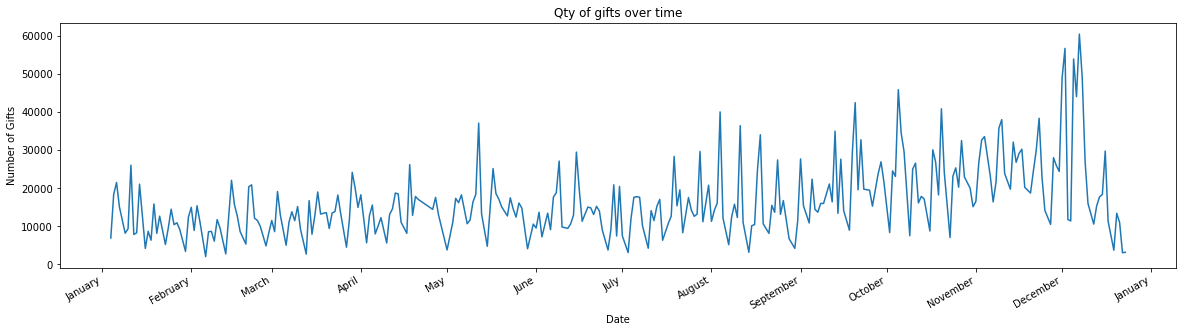

In [26]:
import matplotlib.dates as mdates


plt.figure(figsize=(20,5))
plt.plot(qty_date['InvoiceDay'],qty_date['Quantity'])
plt.title('Qty of gifts over time')
plt.xlabel('Date')
plt.ylabel('Number of Gifts')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()
# plt.show()

In [27]:
qty_date['InvoiceDay'] = qty_date['InvoiceDay'].apply(lambda x: x.strftime('%B-%d'))
qty_date.sort_values(by=['Quantity'], ascending=False).head()

,InvoiceDay,Quantity
283,December-07,60513
278,December-02,56755
281,December-05,53980
284,December-08,49059
277,December-01,49044


<div class="alert alert-success"> 
We can notice a trend of number of gifts increasing towards the second half after October in preparation for the holiday season.
And the trend finally peaks in early December when people have their Christmas shopping
    <br/>
    And, the top 5 days with max quantity purchased are December 7,2,5,8,11.
</div>


### Get Most popular Products

In [28]:
#Get number of unique products
df['Description'].nunique()

3863

In [29]:
#Remove the outlier invoice
df_product = df[df['Quantity']<70000]

#Group by product and sum up quantity
df_product = df_product.groupby(['Description'])['Quantity'].sum().reset_index().sort_values(by=['Quantity'], ascending=False)
df_product.head()

,Description,Quantity
3771,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
1750,JUMBO BAG RED RETROSPOT,46181
3683,WHITE HANGING HEART T-LIGHT HOLDER,36725
206,ASSORTED COLOUR BIRD ORNAMENT,35362
2258,PACK OF 72 RETROSPOT CAKE CASES,33693


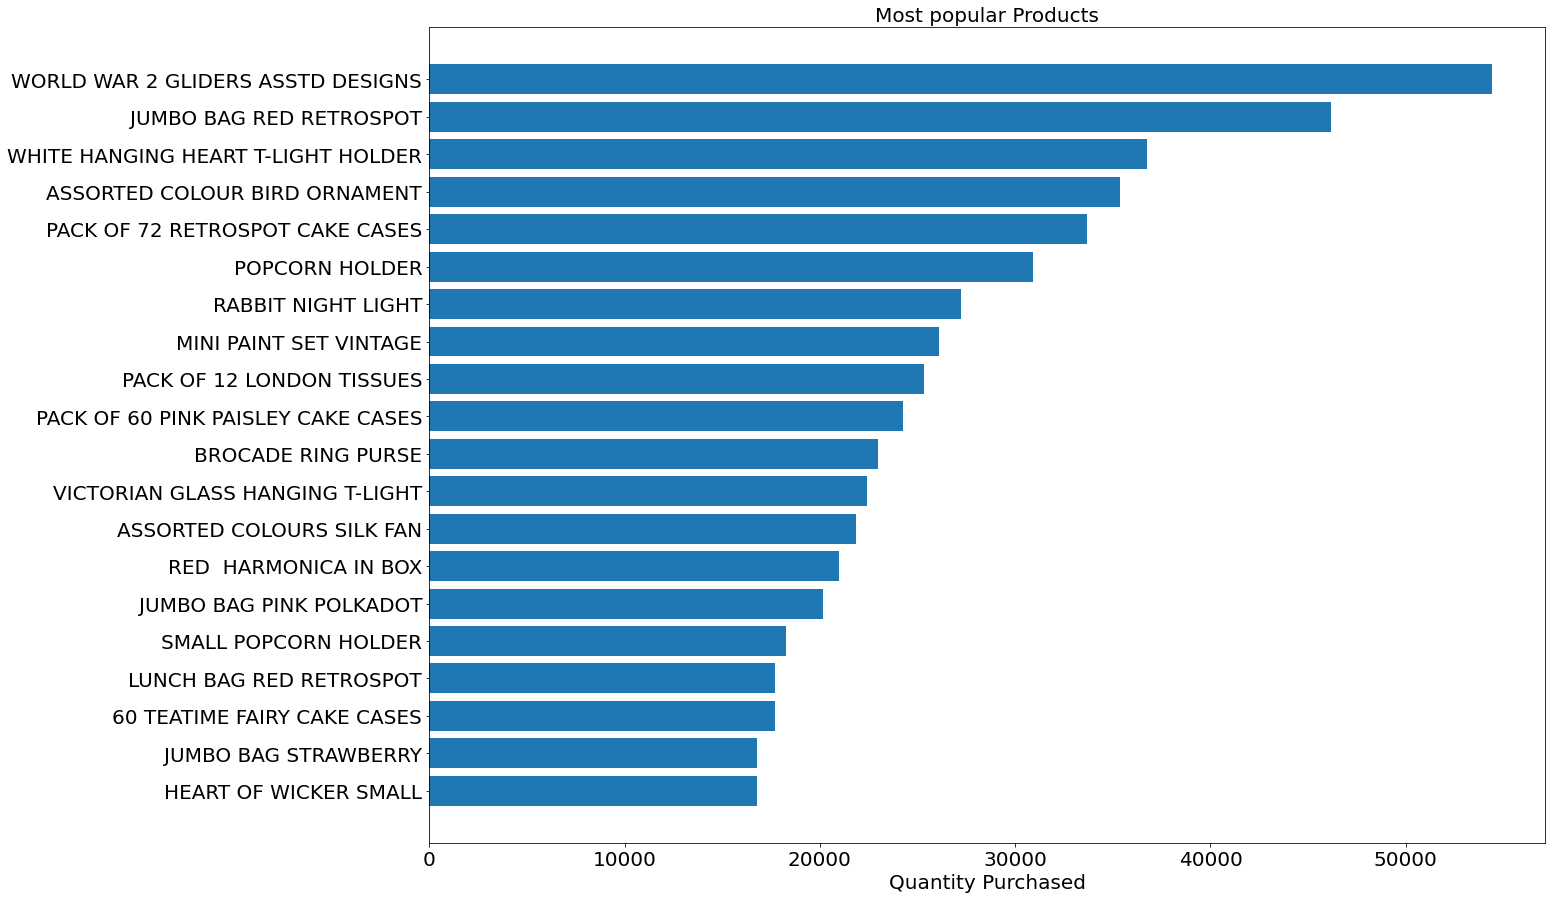

In [30]:
#Plot top 20 only. Reverse order because we want to show descending in barh
df_product_plot = df_product.iloc[:20][::-1]

plt.figure(figsize=(20, 15))
plt.barh(df_product_plot['Description'], df_product_plot['Quantity'])
plt.title("Most popular Products", fontsize=20)
plt.xlabel("Quantity Purchased", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
    
plt.show()

Therefore, `WORLD WAR 2 GLIDERS ASSTD DESIGNS` is the most popular products purchased 

### Get most loyal customers

In [31]:
#Get number of customers
df['CustomerID'].nunique()

4335

In [32]:
#Group by product and sum up quantity
df_customer = df.groupby(['CustomerID'])['InvoiceNo'].nunique().reset_index().sort_values(by=['InvoiceNo'], ascending=False)
df_customer['CustomerID'] = df_customer['CustomerID'].astype(int).astype(str)
df_customer.head()

,CustomerID,InvoiceNo
326,12748,206
1879,14911,199
4008,17841,124
562,13089,97
2176,15311,91


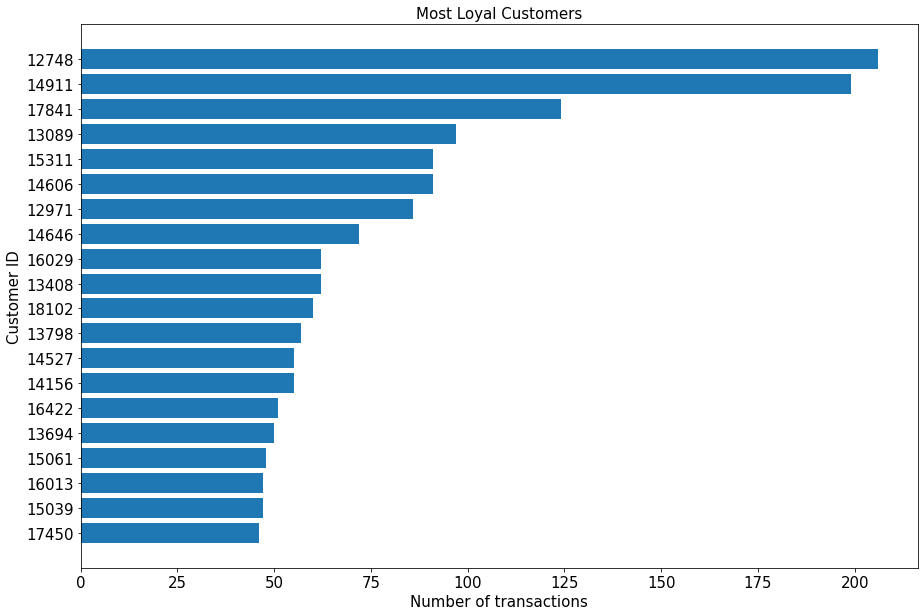

In [33]:
#Plot top 20 only. Reverse order because we want to show descending in barh
df_customer_plot = df_customer.iloc[:20][::-1]

plt.figure(figsize=(15, 10))
plt.barh(df_customer_plot['CustomerID'], df_customer_plot['InvoiceNo'])
plt.title("Most Loyal Customers", fontsize=15)
plt.xlabel("Number of transactions", fontsize=15)
plt.ylabel("Customer ID", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()

## Market Basket Analysis

### MBA on items in france

In [34]:
france_basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [35]:
#Convert those >0 to 1 and 0s to 0
france_basket = france_basket.apply(lambda x: x/x).fillna(0)
france_basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
frequent_itemsets = apriori(france_basket, min_support=0.07, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.073684,(4 TRADITIONAL SPINNING TOPS)
1,0.100000,(ALARM CLOCK BAKELIKE GREEN)
2,0.105263,(ALARM CLOCK BAKELIKE PINK)
3,0.097368,(ALARM CLOCK BAKELIKE RED)
4,0.071053,(ASSORTED COLOUR MINI CASES)


In [37]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0).sort_values(by=['lift'], ascending=False)
rules.tail()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.139474,0.173684,0.092105,0.660377,3.802173,0.067881,2.433041
20,"(PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN WOO...",(PLASTERS IN TIN CIRCUS PARADE),0.107895,0.173684,0.071053,0.658537,3.791574,0.052313,2.419925
25,(PLASTERS IN TIN CIRCUS PARADE),"(PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN WOO...",0.173684,0.107895,0.071053,0.409091,3.791574,0.052313,1.509717
11,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.173684,0.176316,0.105263,0.606061,3.437359,0.074640,2.090891
10,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.176316,0.173684,0.105263,0.597015,3.437359,0.074640,2.050487


### MBA on items in Germany

In [38]:
germany_basket = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [39]:
#Convert those >0 to 1 and 0s to 0
germany_basket = germany_basket.apply(lambda x: x/x).fillna(0)
germany_basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
frequent_itemsets = apriori(germany_basket, min_support=0.07, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.106095,(6 RIBBONS RUSTIC CHARM)
1,0.072235,(ALARM CLOCK BAKELIKE PINK)
2,0.074492,(GUMBALL COAT RACK)
3,0.094808,(JAM MAKING SET PRINTED)
4,0.081264,(JUMBO BAG RED RETROSPOT)


In [41]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0).sort_values(by=['lift'], ascending=False)
rules.tail()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.162528,0.252822,0.135440,0.833333,3.296131,0.094350,4.483070
4,(ROUND SNACK BOXES SET OF4 WOODLAND),(SPACEBOY LUNCH BOX),0.252822,0.106095,0.072235,0.285714,2.693009,0.045412,1.251467
5,(SPACEBOY LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.106095,0.252822,0.072235,0.680851,2.693009,0.045412,2.341159
0,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN WOODLAND ANIMALS),0.252822,0.142212,0.076749,0.303571,2.134637,0.040795,1.231695
1,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.142212,0.252822,0.076749,0.539683,2.134637,0.040795,1.623181


In [147]:
def get_mba_recommendations(prod_selected, n_recommendations, rules=rules):
    recommendations = rules[rules['antecedents']==frozenset({prod_selected})]['consequents'].tolist()[:n_recommendations]
    recommendations = [list(x)[0] for x in recommendations]
    return recommendations

## Recommendation Engine 

### Rank Based Recommendations

In [42]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [43]:
def get_top_products(n, df=df):
    
    # Most popular products
    # Products purchased by most number of customers
    top_products = df.groupby(['Description'])['CustomerID'].nunique().sort_values(ascending=False).iloc[:n].index.tolist()
    return top_products

In [44]:
get_top_products(5), get_top_products(10)

(['REGENCY CAKESTAND 3 TIER',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  'PARTY BUNTING',
  'ASSORTED COLOUR BIRD ORNAMENT',
  'SET OF 3 CAKE TINS PANTRY DESIGN'],
 ['REGENCY CAKESTAND 3 TIER',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  'PARTY BUNTING',
  'ASSORTED COLOUR BIRD ORNAMENT',
  'SET OF 3 CAKE TINS PANTRY DESIGN',
  'PACK OF 72 RETROSPOT CAKE CASES',
  'JUMBO BAG RED RETROSPOT',
  "PAPER CHAIN KIT 50'S CHRISTMAS",
  'NATURAL SLATE HEART CHALKBOARD',
  'BAKING SET 9 PIECE RETROSPOT'])

<div class="alert alert-success"> 
Therefore, if I was recommending a product to a new user, I would recommend "Regency Cakestand 3 Tier" 
</div>

### User-User based collaborative Filtering

In [45]:
def create_user_item_matrix(df_ui):
    '''
    INPUT:
    df - pandas dataframe with description, CustomerID columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and description on the columns with 1 values where a user purchased a product 
    and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df_ui.groupby(['CustomerID', 'Description'])['Description'].nunique().unstack()
    user_item.fillna(0, inplace=True)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To Test whether user item matrix has been built correctly, we can get the results for one user

In [46]:
df[(df['CustomerID']==14307.0) & (df['Description'].isin(['10 COLOUR SPACEBOY PEN', '12 COLOURED PARTY BALLOONS']))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
448,536408,22418,10 COLOUR SPACEBOY PEN,24,2010-12-01,0.85,14307.0,United Kingdom
63665,541588,22418,10 COLOUR SPACEBOY PEN,24,2011-01-19,0.85,14307.0,United Kingdom
281534,561534,22436,12 COLOURED PARTY BALLOONS,20,2011-07-28,0.65,14307.0,United Kingdom


In [47]:
user_item.loc[14307.0:14310.0]

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
14307.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Thus, we see that user 14307 purchased spaceboy pen and party balloons which is why the value in user-item matrix is 1

In [48]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by products: 
                1's when a user has purchased a product, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similar_mat = user_item.dot(user_item.loc[user_id].T)
    # sort by similarity
    most_similar_users = similar_mat.sort_values(ascending=False).index.tolist()

    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [49]:
selected_user_id = 14307.0
user_sim_top10 = find_similar_users(selected_user_id)[:10]
print("The 10 most similar users to user {} are: {}".format(selected_user_id, user_sim_top10))

The 10 most similar users to user 14307.0 are: [14911.0, 12748.0, 14096.0, 17841.0, 14769.0, 13089.0, 14156.0, 14646.0, 13081.0, 17511.0]


In [50]:
#Print the matrix for the users similar to selected_user
user_item.loc[user_sim_top10]

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
14911.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
12748.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14096.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
17841.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
14769.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13089.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14156.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14646.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
13081.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
def get_user_products(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by products: 
                1's when a user has purchased a product, 0 otherwise
    
    OUTPUT:
    products - (list) a list of the products purchased by the user
    
    Description:
    Provides a list of the products that have been purchased by a user
    '''
    # Your code here
    s = pd.Series(user_item.loc[user_id])
    products = s[s == 1].index.tolist()
    
    return products

In [52]:
#Print products purchased by selected_user_id
get_user_products(selected_user_id)

['10 COLOUR SPACEBOY PEN',
 '12 COLOURED PARTY BALLOONS',
 '12 PENCILS TALL TUBE SKULLS',
 '3 PIECE SPACEBOY COOKIE CUTTER SET',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 '36 FOIL HEART CAKE CASES',
 '36 PENCILS TUBE SKULLS',
 '36 PENCILS TUBE WOODLAND',
 '3D HEARTS  HONEYCOMB PAPER GARLAND',
 '4 TRADITIONAL SPINNING TOPS',
 "6 GIFT TAGS 50'S CHRISTMAS",
 '6 ROCKET BALLOONS',
 '60 CAKE CASES VINTAGE CHRISTMAS',
 'AIRLINE BAG VINTAGE TOKYO 78',
 'ANTIQUE SILVER T-LIGHT GLASS',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'BAG 500g SWIRLY MARBLES',
 'BAKING MOULD CHOCOLATE CUPCAKES',
 'BAKING MOULD HEART WHITE CHOCOLATE',
 'BAKING MOULD ROSE MILK CHOCOLATE',
 'BAKING SET 9 PIECE RETROSPOT',
 'BAKING SET SPACEBOY DESIGN',
 'BALLOON PUMP WITH 10 BALLOONS',
 "BISCUIT TIN 50'S CHRISTMAS",
 'BISCUIT TIN VINTAGE CHRISTMAS',
 'BLACK/BLUE POLKADOT UMBRELLA',
 'BLUE COAT RACK PARIS FASHION',
 'BLUE HARMONICA IN BOX',
 'BLUE POLKADOT WRAP',
 "BOX OF 6 MINI 50'S CRACKERS",
 'BOX OF 6 MINI VINTAGE CRACKERS',
 '

In [53]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds products the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended products starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    #We dont want to recommend there
    products_purchased = get_user_products(user_id)
    closest_neighbors = find_similar_users(user_id)
        
    # Keep the recommended movies here
    recs = np.array([])
    
    # Go through the neighbors and identify movies they like the user hasn't seen
    for neighbor in closest_neighbors:
        neighbs_likes = get_user_products(neighbor)[0]
        
        #Obtain recommendations for each neighbor
        new_recs = np.setdiff1d(neighbs_likes, products_purchased, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
    
    return recs # return your recommendations for this user_id  

In [54]:
# Return 10 recommendations for selected user
user_user_recs(selected_user_id, 10)

array(['12 DAISY PEGS IN WOOD BOX', '12 EGG HOUSE PAINTED WOOD',
       '12 IVORY ROSE PEG PLACE SETTINGS',
       '12 MESSAGE CARDS WITH ENVELOPES', '12 PENCIL SMALL TUBE WOODLAND',
       '12 PENCILS SMALL TUBE SKULL', '12 PENCILS TALL TUBE POSY',
       '20 DOLLY PEGS RETROSPOT', '3 GARDENIA MORRIS BOXED CANDLES',
       '3 STRIPEY MICE FELTCRAFT'], dtype='<U32')

### Matrix Factorization

In [55]:
user_item_matrix = user_item.copy()
user_item_matrix.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((4335, 3863), (3863,), (3863, 3863))

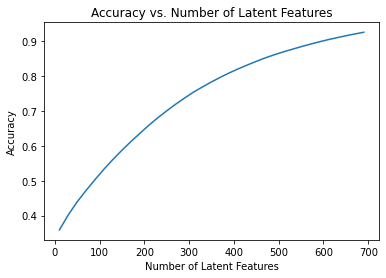

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [58]:
df_train = df.head(int(df.shape[0]*0.8))
df_test = df.tail(int(df.shape[0]*0.2))

In [59]:
len(np.setdiff1d(df_test['Description'], df_train['Description']))

65

<div class="alert alert-danger"> Thus, there are 65 products which are there in test but not in train. <br/>
Because of the cold start problem, we will not be able to predict for this products so we will remove them from test
</div>

In [60]:
df_test = df_test[df_test['Description'].isin(df_train['Description'])]

In [61]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique products for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique products for each column)
    test_idx - all of the test user ids
    test_arts - all of the test products
    
    '''
    # Your code here
    test_idx = df_test['CustomerID'].unique()
    test_prods = df_test['Description'].unique()
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    return user_item_train, user_item_test, test_idx, test_prods

user_item_train, user_item_test, test_idx, test_prods = create_test_and_train_user_item(df_train, df_test)

In [62]:
len(np.intersect1d(df_test['CustomerID'].unique(), df_train['CustomerID'].unique()))

1518

<div class="alert alert-success">
Thus, we have 1,518 users present in both training and test datasets so we can test our recommendations on 1,518 users which is good enough 
</div>

In [63]:
len(np.setdiff1d(df_test['Description'].unique(), df_train['Description'].unique()))

0

<div class="alert alert-success">
All the articles in the test set now occur in the train set as well
</div>

In [64]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)
u_train.shape, s_train.shape, vt_train.shape

((3990, 3798), (3798,), (3798, 3798))

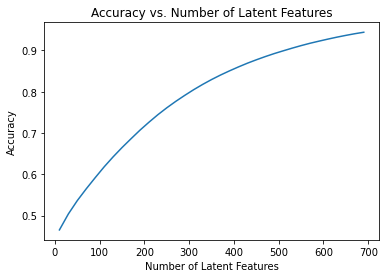

In [65]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [66]:
# Subsetting the test data

row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

col_idxs = user_item_train.columns.isin(test_prods)
vt_test = vt_train[:, col_idxs]

train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

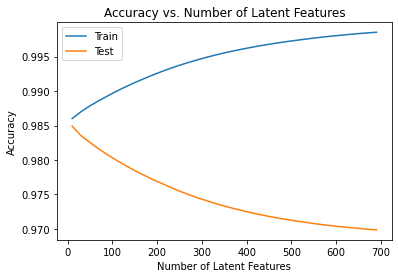

In [67]:
num_latent_feats = np.arange(10, 700+10, 20)
train_errs, test_errs = [], []

for k in num_latent_feats:
    
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))

plt.figure()
plt.plot(num_latent_feats, train_errs, label='Train')
plt.plot(num_latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

<div class="alert alert-success">
We can see accuracy reduce because it becomes overfitting as the number of latent features increase.  <br/>
Accuracy might not be the best metric as well, we can perform an A/B test instead. <br/>
    We can provide users recommendations based on Market Basket Analysis, popular products, user-user collaborative filtering, and matrix factorization and then measure which users respond more
</div>

## Make Recommendations now

In [77]:
num_recommendations = 5

In [79]:
## New User
get_top_products(n = num_recommendations)

['REGENCY CAKESTAND 3 TIER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'PARTY BUNTING',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'SET OF 3 CAKE TINS PANTRY DESIGN']

In [149]:
## New user with one product
prod_selected = 'ROUND SNACK BOXES SET OF4 WOODLAND'
s = get_mba_recommendations(prod_selected, 5)
s

['ROUND SNACK BOXES SET OF 4 FRUITS',
 'SPACEBOY LUNCH BOX',
 'PLASTERS IN TIN WOODLAND ANIMALS']

In [195]:
## Old User
user_selected = 13299.0
sel_user_products = get_user_products(user_selected)
sel_user_recs = user_user_recs(user_selected)
print("Products used by user %s "%str(user_selected))
print(sel_user_products)
print("Products recommended")
print(sel_user_recs)

Products used by user 13299.0 
['NATURAL SLATE CHALKBOARD LARGE', 'NATURAL SLATE HEART CHALKBOARD', 'PICNIC BASKET WICKER LARGE', 'ROSES REGENCY TEACUP AND SAUCER', 'ROUND SNACK BOXES SET OF4 WOODLAND']
Products recommended
['10 COLOUR SPACEBOY PEN' '12 COLOURED PARTY BALLOONS'
 '12 EGG HOUSE PAINTED WOOD' '12 IVORY ROSE PEG PLACE SETTINGS'
 '12 MESSAGE CARDS WITH ENVELOPES' '15CM CHRISTMAS GLASS BALL 20 LIGHTS'
 '200 RED + WHITE BENDY STRAWS' '3 HOOK PHOTO SHELF ANTIQUE WHITE'
 "3 RAFFIA RIBBONS 50'S CHRISTMAS" '3 WHITE CHOC MORRIS BOXED CANDLES']


In [199]:
most_similar_user = find_similar_users(user_selected)[0]
sim_user_products = get_user_products(most_similar_user)
products_purchased_by_both_users = np.intersect1d(sel_user_products, sim_user_products)
print("Most similar user: %s"%str(most_similar_user))
print("Products purchased by most similar user:")
print(products_purchased_by_both_users)

Most similar user: 14156.0
Products purchased by most similar user:
['NATURAL SLATE CHALKBOARD LARGE' 'NATURAL SLATE HEART CHALKBOARD'
 'PICNIC BASKET WICKER LARGE' 'ROSES REGENCY TEACUP AND SAUCER'
 'ROUND SNACK BOXES SET OF4 WOODLAND']


<div class="alert alert-success"> 
Therefore, we can see that user 14156.0 is most similar to user 13299 because 14156 has purchased ALL the same products as user 13299
</div>